In [1]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

import seaborn as sns 
import pandas as pd 
import numpy as np 
import tensorflow.compat.v2 as tf 
import tensorflow_probability as tfp 

from tensorflow_probability import sts 

import tf_keras
import collections 

# Helper Code for Plotting

In [2]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast


    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
        x[num_steps_train],
        x[num_steps_train]+num_steps_forecast,
        dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color="red",
            label='forecast')
    ax.fill_between(forecast_steps,
                    forecast_mean-2*forecast_scale,
                    forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

# No Linear Regression Code

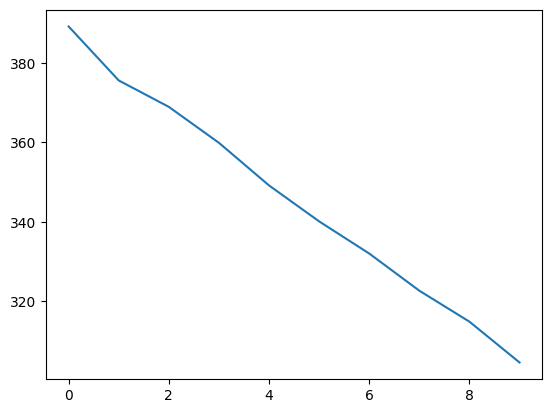

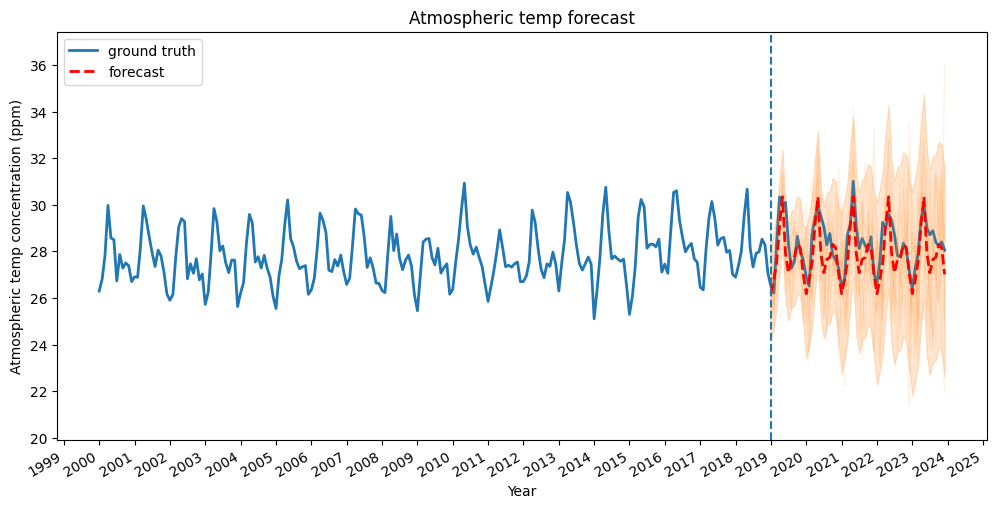

In [4]:
# Set Data
df = pd.read_csv("CombinedData.csv")[["datetime", "temp"]]
df["Month"] = pd.DatetimeIndex(df["datetime"]).month 
df["Year"] = pd.DatetimeIndex(df["datetime"]).year 
df["MonthYear"] = df["Year"] * 10_000 + df["Month"]
mm_df = df.groupby(by="MonthYear").mean(numeric_only = True)["temp"]
temp_by_month = mm_df.to_numpy()

num_forecast_steps = 12 * 5
temp_by_month_training_data = temp_by_month[:-num_forecast_steps]

temp_dates = np.arange("2000-01", "2024-01", dtype="datetime64[M]")
temp_loc = mdates.YearLocator(1) # Every Year
temp_fmt = mdates.DateFormatter('%Y')

# Model Definition
# trend = sts.SemiLocalLinearTrend(observed_time_series = temp_by_month_training_data)
seasonal = sts.Seasonal(num_seasons = 12, observed_time_series = temp_by_month_training_data)

total_model = [
    # trend,
    seasonal
]

temp_model = sts.Sum(total_model, observed_time_series = temp_by_month_training_data)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model = temp_model)
num_variational_steps = int(10)

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temp_model.joint_distribution(
        observed_time_series=temp_by_month_training_data).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf_keras.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

q_samples_temp_ = variational_posteriors.sample(50)

temp_forecast_dist = tfp.sts.forecast(
    temp_model,
    observed_time_series=temp_by_month_training_data,
    parameter_samples=q_samples_temp_,
    num_steps_forecast=num_forecast_steps)

num_samples=10

temp_forecast_mean, temp_forecast_scale, temp_forecast_samples = (
    temp_forecast_dist.mean().numpy()[..., 0],
    temp_forecast_dist.stddev().numpy()[..., 0],
    temp_forecast_dist.sample(num_samples).numpy()[..., 0])

fig, ax = plot_forecast(
    temp_dates, temp_by_month,
    temp_forecast_mean, temp_forecast_scale, temp_forecast_samples,
    x_locator=temp_loc,
    x_formatter=temp_fmt,
    title="Atmospheric temp forecast")

ax.axvline(temp_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric temp concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()

# Linear Regression Working Code

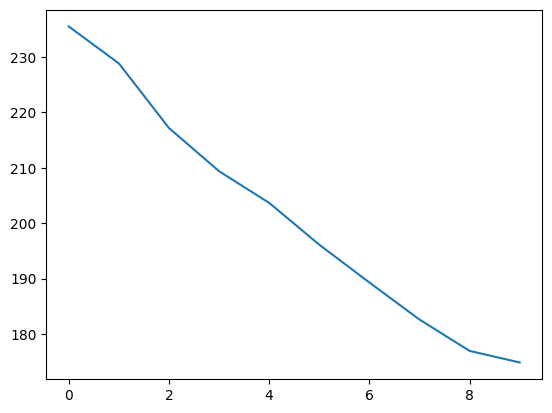

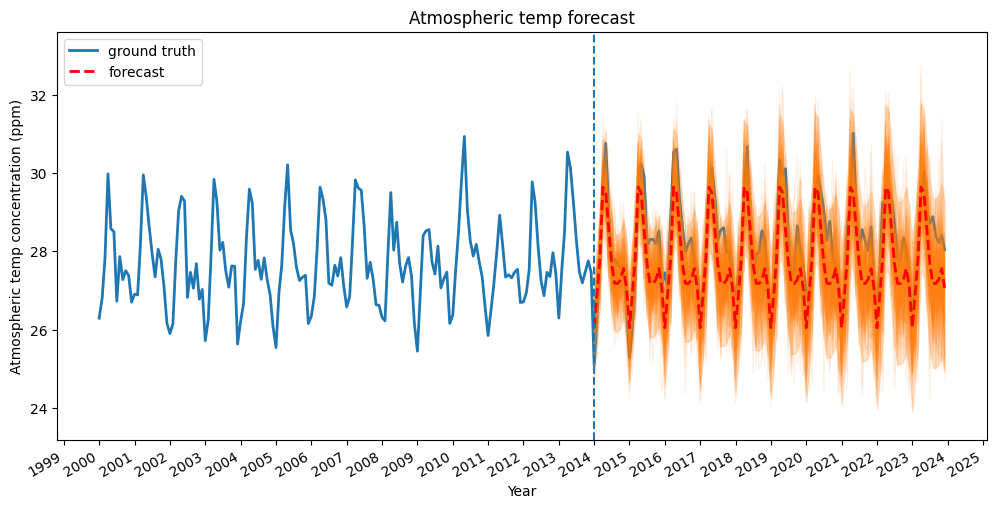

In [73]:
# Set Data
df = pd.read_csv("CombinedData.csv")[["datetime", "temp"]]
df["Month"] = pd.DatetimeIndex(df["datetime"]).month 
df["Year"] = pd.DatetimeIndex(df["datetime"]).year 
df["MonthYear"] = df["Year"] * 10_000 + df["Month"]
mm_df = df.groupby(by="MonthYear").mean(numeric_only = True)["temp"]
temp_by_month = mm_df.to_numpy()

num_forecast_steps = 12 * 10
temp_by_month_training_data = temp_by_month[:-num_forecast_steps]

temp_dates = np.arange("2000-01", "2024-01", dtype="datetime64[M]")
temp_loc = mdates.YearLocator(1) # Every Year
temp_fmt = mdates.DateFormatter('%Y')

# Model Definition
# trend = sts.SemiLocalLinearTrend(observed_time_series = temp_by_month_training_data)
seasonal = sts.Seasonal(num_seasons = 12, observed_time_series = temp_by_month_training_data)

linRegEff = sts.LinearRegression(design_matrix = tf.reshape(temp_by_month - np.mean(temp_by_month), (-1, 1)), name = "LinRegEffect")

total_model = [
    seasonal,
    # linRegEff
]

temp_model = sts.Sum(total_model, observed_time_series = temp_by_month_training_data)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model = temp_model)
num_variational_steps = int(10)

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temp_model.joint_distribution(
        observed_time_series=temp_by_month_training_data).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf_keras.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

q_samples_temp_ = variational_posteriors.sample(num_forecast_steps)

temp_forecast_dist = tfp.sts.forecast(
    temp_model,
    observed_time_series=temp_by_month_training_data,
    parameter_samples=q_samples_temp_,
    num_steps_forecast=num_forecast_steps)

# Was 50 Before
num_samples = num_forecast_steps

temp_forecast_mean, temp_forecast_scale, temp_forecast_samples = (
    temp_forecast_dist.mean().numpy()[..., 0],
    temp_forecast_dist.stddev().numpy()[..., 0],
    temp_forecast_dist.sample(num_samples).numpy()[..., 0])

fig, ax = plot_forecast(
    temp_dates, temp_by_month,
    temp_forecast_mean, temp_forecast_scale, temp_forecast_samples,
    x_locator=temp_loc,
    x_formatter=temp_fmt,
    title="Atmospheric temp forecast")

ax.axvline(temp_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric temp concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()

In [74]:
q_samples = variational_posteriors.sample(2000)

OrderedDict([('observation_noise_scale',
              <tf.Tensor: shape=(2000,), dtype=float64, numpy=
              array([0.40399688, 0.39782944, 0.41777832, ..., 0.42027576, 0.40388044,
                     0.3955946 ])>),
             ('Seasonal/_drift_scale',
              <tf.Tensor: shape=(2000,), dtype=float64, numpy=
              array([0.43238328, 0.43134208, 0.43526135, ..., 0.4315727 , 0.44933253,
                     0.43134533])>),
             ('LinRegEffect/_weights',
              <tf.Tensor: shape=(2000, 1), dtype=float64, numpy=
              array([[0.37149151],
                     [0.35900569],
                     [0.3625485 ],
                     ...,
                     [0.34333753],
                     [0.34328291],
                     [0.35413452]])>)])

In [75]:
preds = tfp.sts.forecast(
    temp_model,
    observed_time_series=temp_by_month_training_data,
    parameter_samples=q_samples_temp_,
    num_steps_forecast=1000)

In [76]:
preds.mean()

<tf.Tensor: shape=(1000, 1), dtype=float64, numpy=
array([[26.0562339 ],
       [26.95068614],
       [27.81584883],
       [29.64069527],
       [29.5018915 ],
       [28.56179317],
       [27.69175586],
       [27.18774768],
       [27.18284728],
       [27.28357717],
       [27.56281419],
       [27.07465172],
       [26.0562339 ],
       [26.95068614],
       [27.81584883],
       [29.64069527],
       [29.5018915 ],
       [28.56179317],
       [27.69175586],
       [27.18774768],
       [27.18284728],
       [27.28357717],
       [27.56281419],
       [27.07465172],
       [26.0562339 ],
       [26.95068614],
       [27.81584883],
       [29.64069527],
       [29.5018915 ],
       [28.56179317],
       [27.69175586],
       [27.18774768],
       [27.18284728],
       [27.28357717],
       [27.56281419],
       [27.07465172],
       [26.0562339 ],
       [26.95068614],
       [27.81584883],
       [29.64069527],
       [29.5018915 ],
       [28.56179317],
       [27.69175586],
   

['_Distribution__cached_batch_shape',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_allow_nan_stats',
 '_batch_shape',
 '_batch_shape_tensor',
 '_broadcast_parameters_with_batch_shape',
 '_call_cdf',
 '_call_log_cdf',
 '_call_log_prob',
 '_call_log_survival_function',
 '_call_prob',
 '_call_quantile',
 '_call_sample_and_log_prob',
 '_call_sample_n',
 '_call_survival_function',
 '_call_unnormalized_log_prob',
 '_checkpoint_dependencies',
 '_components_distribution',
 '_

In [69]:
for param in temp_model.parameters:
    print(param.name, q_samples_temp_[param.name][0])

observation_noise_scale tf.Tensor(0.40664468579273244, shape=(), dtype=float64)
Seasonal/_drift_scale tf.Tensor(0.43214145474068677, shape=(), dtype=float64)
LinRegEffect/_weights tf.Tensor([0.35437978], shape=(1,), dtype=float64)


In [ ]:
q_samples

In [53]:
temp_forecast_mean[0], temp_forecast_scale[0]

(25.539225747200916, 0.6522803554779949)

# Hamlitonian Fit Code

In [38]:
# Sample time series data (replace with your actual data)
# data = tf.constant([10, 12, 15, 11, 14, 16, 13, 17])

data = np.array(temp_by_month_training_data, dtype = "float32")

num_forecast_steps = 100

# Define a simple STS model with trend and seasonality
seasonality1 = sts.Seasonal(
    num_seasons=12,  # Adjust seasonality based on your data
    observed_time_series=data,
    name = "Monthly Seasonality"
)

seasonality2 = sts.Seasonal(
    num_seasons=4,  # Adjust seasonality based on your data
    observed_time_series=data,
    name = "Quarterly Seasonality"
)

linReg = sts.LinearRegression(
    design_matrix = tf.reshape(data - np.mean(data), (-1, 1)),
    name = "Lin Reg"
)

model = sts.Sum([
    seasonality1,
    seasonality2,
    linReg
])

# Train the model (more complex models may require additional configuration)
samples, kernel_results = tfp.sts.fit_with_hmc(
    model = model, 
    observed_time_series = data,
    num_results = 100
)

# Predict future values (specify number of steps to forecast)
forecast_dist = tfp.sts.forecast(
    model = model,
    observed_time_series = data,
    num_steps_forecast = num_forecast_steps,
    parameter_samples = samples
)

# Get the predicted mean and standard deviation
forecast_mean = forecast_dist.mean().numpy().flatten()
forecast_stddev = forecast_dist.stddev().numpy().flatten()




c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


InvalidArgumentError: {{function_node __wrapped__GatherV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices = 228 is not in [0, 228) [Op:GatherV2] name: 

In [30]:
forecast_mean * 2

array([-0.5246736 , -0.4025148 ,  0.00134338,  0.6070422 ,  0.55003524,
        0.21287298, -0.03637416,  0.03808419, -0.0395048 , -0.0893679 ,
       -0.08974662, -0.22719613, -0.5246736 , -0.40251482,  0.0013434 ,
        0.6070422 ,  0.55003524,  0.212873  , -0.03637415,  0.03808418,
       -0.03950479, -0.0893679 , -0.08974662, -0.22719613, -0.5246736 ,
       -0.40251482,  0.0013434 ,  0.6070422 ,  0.55003524,  0.21287298,
       -0.03637415,  0.03808418, -0.0395048 , -0.0893679 , -0.08974662,
       -0.22719613, -0.5246736 , -0.40251482,  0.0013434 ,  0.6070422 ,
        0.55003524,  0.21287298, -0.03637415,  0.03808418, -0.0395048 ,
       -0.0893679 , -0.08974662, -0.22719613, -0.5246736 , -0.40251482,
        0.0013434 ,  0.6070422 ,  0.55003524,  0.21287298, -0.03637415,
        0.03808418, -0.0395048 , -0.0893679 , -0.08974662, -0.22719613,
       -0.5246736 , -0.40251482,  0.0013434 ,  0.6070422 ,  0.55003524,
        0.21287298, -0.03637415,  0.03808418, -0.0395048 , -0.08

In [29]:
forecast_stddev

array([28.482985, 28.482948, 28.482912, 28.482943, 28.48305 , 28.48304 ,
       28.483047, 28.483074, 28.483164, 28.483185, 28.483206, 28.483221,
       28.484194, 28.484156, 28.484121, 28.484154, 28.484259, 28.484247,
       28.484257, 28.484283, 28.484371, 28.484394, 28.484413, 28.48443 ,
       28.485401, 28.485367, 28.48533 , 28.48536 , 28.485466, 28.485455,
       28.485464, 28.485489, 28.48558 , 28.485601, 28.485622, 28.485638,
       28.48661 , 28.486574, 28.48654 , 28.486568, 28.486673, 28.486666,
       28.486671, 28.486698, 28.486792, 28.48681 , 28.48683 , 28.486845,
       28.487818, 28.487782, 28.48775 , 28.487778, 28.487883, 28.487871,
       28.48788 , 28.487907, 28.487997, 28.488018, 28.488039, 28.488054,
       28.489027, 28.48899 , 28.488956, 28.488985, 28.48909 , 28.48908 ,
       28.48909 , 28.489115, 28.489206, 28.489225, 28.489248, 28.489264,
       28.490234, 28.490198, 28.490166, 28.490192, 28.4903  , 28.49029 ,
       28.490297, 28.490324, 28.490414, 28.490435, 

In [36]:
# forecast_pred = forecast_mean * 4 + forecast_stddev - 1/2 * forecast_stddev

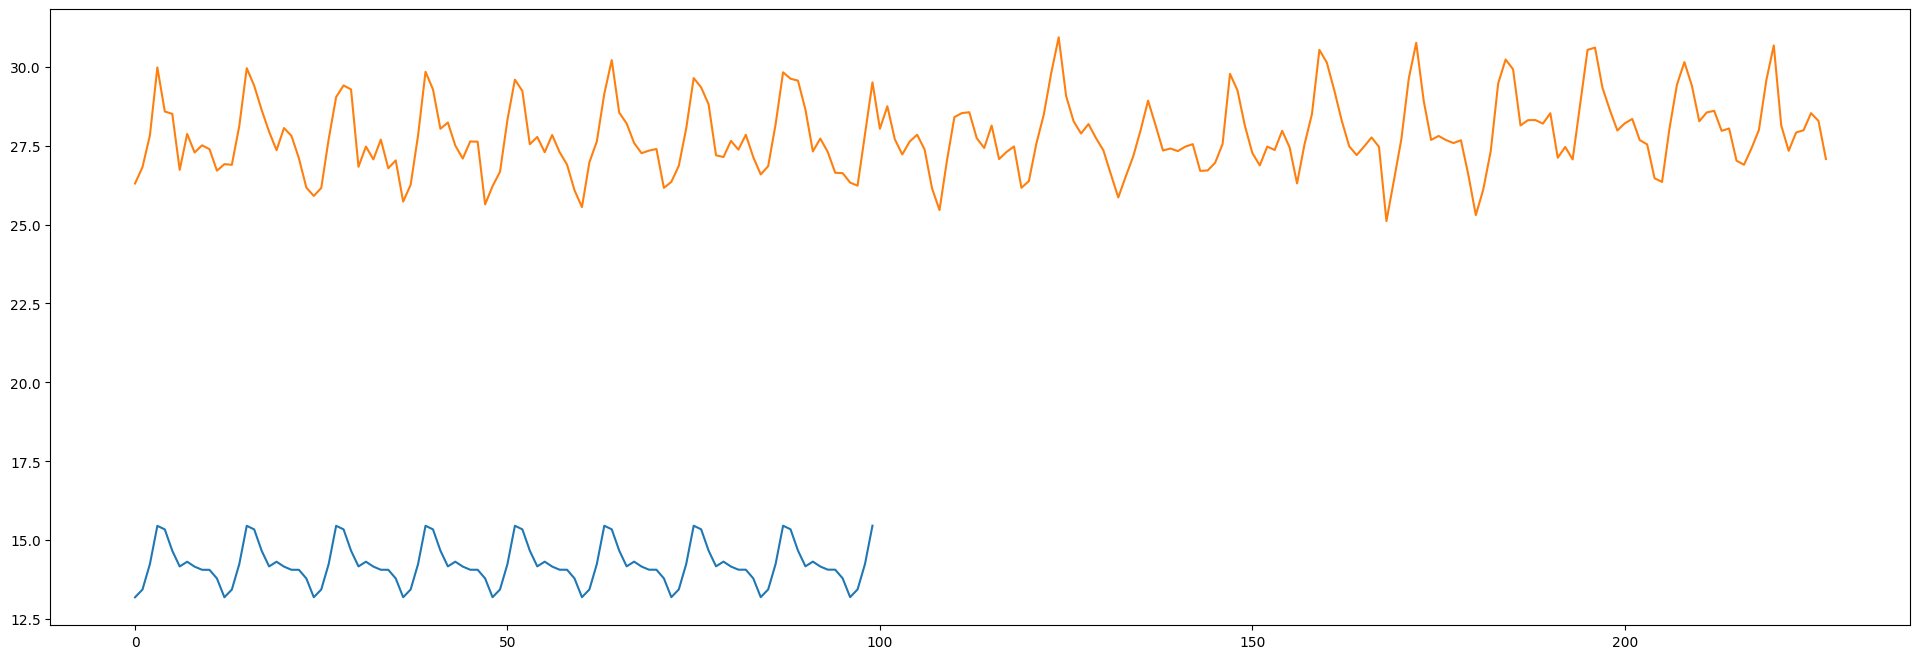

In [37]:
training_idx = np.arange(0, len(temp_by_month_training_data))
forecast_idx = np.arange(len(temp_by_month_training_data), len(forecast_pred))
plt.figure(figsize = (24, 8))
plt.plot(forecast_pred)
plt.plot(temp_by_month_training_data)
plt.show()